In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

In [0]:
def load_dataset():
    train = h5py.File("train_catvnoncat.h5", "r")
    train_x = np.array(train["train_set_x"][:])
    train_y = np.array(train["train_set_y"][:])
    
    test = h5py.File("test_catvnoncat.h5", "r")
    test_x = np.array(test["test_set_x"][:])
    test_y = np.array(test["test_set_y"][:])
    
    classes = np.array(test["list_classes"][:])
    
    train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))
    
    return train_x, train_y, test_x, test_y, classes

In [16]:
training_data = pd.read_csv("train.csv", sep=',')

train_x_orig = training_data.head(30000).iloc[:, 1:785]
train_y = training_data.head(30000).iloc[:, 0]

test_x_orig = training_data.tail(12000).iloc[:, 1:785]
test_y = training_data.tail(12000).iloc[:, 0]

train_x_orig = train_x_orig.as_matrix().reshape(30000, 784)
test_x_orig = test_x_orig.as_matrix().reshape(12000, 784)
train_y = train_y.as_matrix().reshape(1, 30000)
test_y = test_y.as_matrix().reshape(1, 12000)

#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')


#train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()
#print(classes)

m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = int(np.sqrt(train_x_orig.shape[1]))

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Image size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 30000
Number of testing examples: m_test = 12000
Height/Width of each image: num_px = 28
Image size: (28, 28, 3)
train_x shape: (30000, 784)
train_y shape: (1, 30000)
test_x shape: (12000, 784)
test_y shape: (1, 12000)


y = [2] picture.


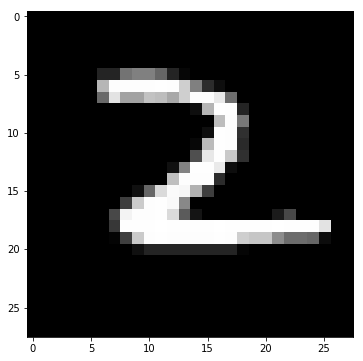

In [18]:
index = 56
plt.imshow(train_x_orig[index, :].reshape(28,28))
#print(train_y[:, index])
print("y = " + str(train_y[:, index]) + " picture.")

In [19]:
train_x = train_x_orig.T
test_x = test_x_orig.T

print("train_x shape: " + str(train_x.shape))
print("test_x shape: " + str(test_x.shape))

train_x shape: (784, 30000)
test_x shape: (784, 12000)


In [20]:
train_x = train_x / 255
test_x = test_x / 255

### Initialization

In [22]:
def init_params(dims):
    params = {}
    np.random.seed(1)
    
    for i in range (1, len(dims)):
        if(len(dims) <= 3):
            params["W" + str(i)] = np.random.randn(dims[i], dims[i-1]) * 0.01 
        else:
            params["W" + str(i)] = np.random.randn(dims[i], dims[i-1]) / np.sqrt(dims[i-1])
        
        params["b" + str(i)] = np.zeros((dims[i], 1))
    
    return params

In [23]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [24]:
def relu(z):
    return np.maximum(0, z)

In [25]:
def forward_prop(X, params):
    L = len(params) // 2
    A = X
    caches = []
    
    for i in range(1, L+1):
        A_prev = A
        
        W = params["W" + str(i)]
        b = params["b" + str(i)]
                   
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
        
        if(i == L):
            A = sigmoid(Z)
        else:
            A = relu(Z)
        
        activation_cache = Z
        
        caches.append((linear_cache, activation_cache))
        
    return A, caches

In [75]:
def compute_cost(Y, AL):
    m = Y.shape[1]
    
    y_vector = np.array([0,1,2,3,4,5,6,7,8,9]).reshape(10,1)
    print(Y[:,0])

    y_temp = np.zeros((10, m))
    for i in range(m):
        y_temp = np.concatenate((y_temp, y_vector==Y[:,i]), axis=1)
    Y = y_temp
    
    print(y_vector == Y[:,0])
    print(y_temp[:,0])
    print(Y)
    
    J = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    
    return np.squeeze(J)

In [27]:
def sigmoid_backward(dA, Z):
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [28]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ

In [71]:
def backward_prop(AL, Y, caches):
    L = len(caches)
    m = AL.shape[1]
    
    y_vector = np.array([0,1,2,3,4,5,6,7,8,9])
    
    y_temp = np.zeros((10, m))
    for i in range(m):
        y_temp[:,i] = (y_vector == np.squeeze(Y[:,i]))
    Y = y_temp
    #print(Y.shape)
    
    grads = {}
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    for i in range(L, 0, -1):
        current_cache = caches[i-1]
        
        linear_cache, activation_cache = current_cache
        
        if(i == L):
            dZ = sigmoid_backward(dAL, activation_cache)
        else:
            dZ = relu_backward(grads["dA" + str(i+1)], activation_cache)
        
        A_prev, W, b = linear_cache
        
        grads["dW" + str(i)] = (1/m) * np.dot(dZ, A_prev.T)
        grads["db" + str(i)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)        
        grads["dA" + str(i)] = np.dot(W.T, dZ)
        
    return grads

In [30]:
def update_params(params, grads, learning_rate):
    L = len(params) // 2
    
    for l in range(1, L+1):
        params["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        params["b" + str(l)] -= learning_rate * grads["db" + str(l)]
        
    return params

In [47]:
def NN_model(X, Y, dims, learning_rate = 0.3, num_itrs = 3000, print_cost = False):
    np.random.seed(1)
    
    params = init_params(dims)
    costs = []
    
    for i in range(num_itrs):   
        AL, caches = forward_prop(X, params)
        #print(AL.shape)
        cost = compute_cost(Y, AL)
        
        grads = backward_prop(AL, Y, caches)
        
        params = update_params(params, grads, learning_rate)
        
        if(i % 100 == 0):
            costs.append(cost)
            
            if(print_cost):
                print("Iteration #%i : %f" % (i, cost))
     
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return params

In [76]:
dims = [784, 7, 10]
params = NN_model(train_x, train_y, dims, learning_rate = 0.0075, num_itrs = 2500, print_cost=True)

[1]


KeyboardInterrupt: 

In [ ]:
def predict(X, Y, params):
    predictions = np.zeros(Y.shape)
    y, caches = forward_prop(X, params)
    
    for i in range(y.shape[1]):
        if(y[0, i] >= 0.5):
            predictions[0, i] = 1
        else:
            predictions[0, i] = 0
    
    print("Accuracy : " + str(np.sum((predictions == Y) / X.shape[1])))
    
    return predictions

In [ ]:
predictions_train = predict(train_x, train_y, params)

In [ ]:
predictions_test = predict(test_x, test_y, params)

In [ ]:
layers_dims = [12288, 20, 7, 5, 1]
params = NN_model(train_x, train_y, layers_dims, learning_rate = 0.0075, num_itrs = 2500, print_cost=True)

In [ ]:
pred_train = predict(train_x, train_y, params)

In [ ]:
pred_train = predict(test_x, test_y, params)